In [42]:
import os
import time
import torch
import subprocess as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

%matplotlib inline

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
base_path = sp.getoutput('git rev-parse --show-toplevel')
os.chdir(base_path)

from src import embed, pred_models, model_helpers

### Data Preparation

In [45]:
# Load data
data_dir = 'data'
file = 'utterances_clean2014-2018.csv'
df_raw = pd.read_csv(os.path.join(base_path, data_dir, file))

In [46]:
# Load data
# set folder path
folder_path = "data/"

# get list of files in folder
file_list = os.listdir(folder_path)

# create empty list to hold dataframes
df_list = []

# loop through files in folder
for file in file_list:
    # check if file is a CSV
    if file.endswith('.csv'):
        # read CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file))
        # append dataframe to list
        df_list.append(df)

# concatenate all dataframes in list into a single dataframe
combined_df = pd.concat(df_list, axis=0, ignore_index=True)
df_raw = combined_df

In [47]:
# Have to do by utterance as grouping by case_id gives too few examples to learn from
df = df_raw[['text', 'win_side', 'case_id']]
df.head()

,text,win_side,case_id
0,"-- United States. Mr. Hayes, you may continue ...",1.0,1961_41
1,May I should like to call attention to the rep...,1.0,1961_41
2,"May, I ask you please, is this matter in conte...",1.0,1961_41
3,"Not quite, Your Honor. And may I refer directl...",1.0,1961_41
4,I thought he conceded that?,1.0,1961_41


In [48]:
# Keep only cases with outcomes 0 or 1
df = df[df.win_side.isin([0, 1])]

In [49]:
# Get unique case_ids
unique_case_ids = df['case_id'].unique()

# Split the unique case_ids into training and testing sets
train_case_ids, test_case_ids = train_test_split(unique_case_ids, test_size=0.2, random_state=123)

# Filter the original dataframe to create the train and test dataframes using the train and test case_ids
train_df = df[df['case_id'].isin(train_case_ids)]
test_df = df[df['case_id'].isin(test_case_ids)]


In [50]:
display(train_case_ids.shape)
display(test_case_ids.shape)

(1357,)

(340,)

### BoW Embedding

In [51]:
# Bag of Words
vocab = embed.get_vocab(train_df, min_freq=100)
vocab_size = len(vocab)
vocab_size

20551

### Create training, validation, and testing dataloaders

In [52]:
BATCH_SIZE = 64

train_df = train_df[['text', 'win_side']] # Remove case ID for training
train_valid_data = list(train_df.values)
num_train = int(len(train_valid_data) * 0.85)
num_valid = len(train_valid_data) - num_train
train_data, valid_data = random_split(
    train_valid_data, [num_train, num_valid])
test_data = list(test_df[['text', 'win_side']].values)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=lambda batch: embed.collate_into_bow(batch, vocab)) # pass vocab to collate function
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=lambda batch: embed.collate_into_bow(batch, vocab))
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=lambda batch: embed.collate_into_bow(batch, vocab))

### Training

In [53]:
# BoW NN Classifier
hidden_dim = 500
model = pred_models.BoWNNClassifier(vocab_size=vocab_size, hidden_dim=hidden_dim, output_dim=1)

In [55]:
import numpy as np
EPOCHS = 15
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

best_model = None
best_val_loss = float('inf')
val_losses = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model_helpers.train_an_epoch(model, train_dataloader, optimizer, loss_function)
    val_y_true, val_y_pred = model_helpers.make_predictions(model, valid_dataloader)
    val_loss = log_loss(val_y_true.astype(np.float64), val_y_pred.astype(np.float64))
    if val_loss < best_val_loss:
        best_model = type(model)(model.vocab_size, model.hidden_dim, model.output_dim) # get a new instance
        best_model.load_state_dict(model.state_dict())
        best_val_loss = val_loss
    val_losses.append(val_loss)
    time_taken = time.time() - epoch_start_time
    print(f'After epoch {epoch} the validation loss is {val_loss:.3f}.')
    
plt.plot(range(1, EPOCHS+1), val_losses)

At iteration 500 the train loss is 0.628.
At iteration 1000 the train loss is 0.606.
At iteration 1500 the train loss is 0.553.
At iteration 2000 the train loss is 0.599.
At iteration 2500 the train loss is 0.612.
At iteration 3000 the train loss is 0.633.
At iteration 3500 the train loss is 0.692.
At iteration 4000 the train loss is 0.671.
At iteration 4500 the train loss is 0.532.
At iteration 5000 the train loss is 0.635.
After epoch 1 the validation loss is 0.615.
At iteration 500 the train loss is 0.630.
At iteration 1000 the train loss is 0.624.
At iteration 1500 the train loss is 0.619.
At iteration 2000 the train loss is 0.613.
At iteration 2500 the train loss is 0.655.
At iteration 3000 the train loss is 0.547.


KeyboardInterrupt: 

Best Threshold=0.653559, G-Mean=0.708


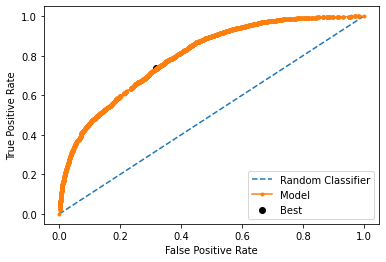

In [ ]:
# Get validation predictions to select best threshold
val_labels, val_probs = model_helpers.make_predictions(model, valid_dataloader)
# Get best threshold from validation data
threshold = model_helpers.select_threshold(val_labels, val_probs)

### Evaluation

In [ ]:
# Get dataframe with predictions and real values
test_results_df = model_helpers.get_test_results_df(best_model, test_dataloader, test_df[['case_id', 'win_side']])
test_results_df.head()

,case_id,win_side,labels,prob
2352,2014_13-894,0.0,0.0,0.353726
2353,2014_13-894,0.0,0.0,0.798379
2354,2014_13-894,0.0,0.0,0.777325
2355,2014_13-894,0.0,0.0,0.966327
2356,2014_13-894,0.0,0.0,0.730220


In [ ]:
# Results dataframe per utterance
per_utterance_df = (test_results_df
                    .assign(pred=lambda x: x['prob']
                    .apply(lambda y: 1 if y > threshold else 0)))

# petitioner 1, respondent 0
display(per_utterance_df.pred.value_counts())
per_utterance_df.win_side.value_counts()

1    8978
0    6689
Name: pred, dtype: int64

1.0    9666
0.0    6001
Name: win_side, dtype: int64

In [ ]:
# Results dataframe per case
per_case_df = (test_results_df
                .groupby('case_id')
                .mean()
                .assign(pred=lambda x: x['prob']
                .apply(lambda y: 1 if y > threshold else 0)))

# petitioner 1, respondent 0
display(per_case_df.pred.value_counts())
per_case_df.win_side.value_counts()

1    39
0    24
Name: pred, dtype: int64

1.0    38
0.0    25
Name: win_side, dtype: int64

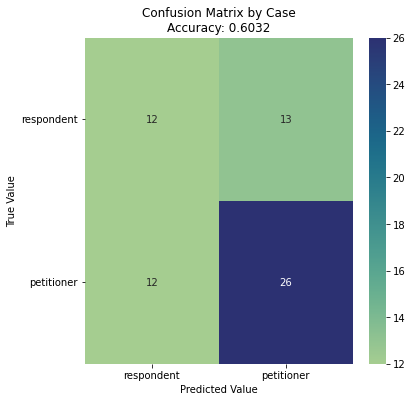

In [ ]:
# Confusion matrix by case
model_helpers.results_heatmap(per_case_df['win_side'],
                per_case_df['pred'],
                'Confusion Matrix by Case',
                target_names = ['respondent', 'petitioner'])

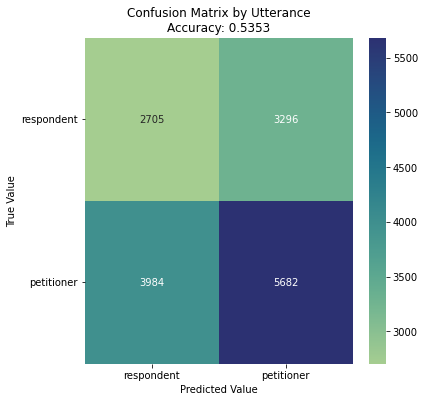

In [ ]:
# Confusion matrix by utterance
model_helpers.results_heatmap(per_utterance_df['win_side'],
                per_utterance_df['pred'],
                'Confusion Matrix by Utterance',
                target_names = ['respondent', 'petitioner'])